# Анализ продаж и оценок компьютерных игр для планирования рекламных компаний в магазине «Стримчик»

## Описание проекта

Проект заключается в анализе исторических данных продаж компьютерных игр, доступных из открытых источников, для интернет-магазина «Стримчик». Данные включают в себя оценки пользователей и экспертов, жанры, платформы и возрастной рейтинг игр от ассоциации ESRB. 

Цель проекта - выявить определяющие успешность игры закономерности, которые позволят сделать ставку на потенциально популярные продукты и спланировать рекламные кампании. Работа с данными будет проводиться на исторических примерах до 2016 года, далее предстоит отработать принцип работы с данными для прогнозирования продаж в будущем.

## Описание входных данных

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию

## Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from matplotlib.lines import Line2D

sns.set_style("darkgrid")
warnings.filterwarnings("ignore") 

## Загрузка данных и анализ общей информации

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
except:
    data = pd.read_csv('games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# приведем названия в нижний регистр
cols = data.columns.str.lower()
data.columns = cols

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Скорректируем тип данных в факторе `user_score` предварительно заменив tbd (подлежит уточнению) на пустые значения, поскольку конкретный пользовательский рейтинг получен не был

In [6]:
data['user_score'] = data['user_score'].apply(lambda x: np.nan if x=='tbd' else x).astype('float64')

In [7]:
data.describe(include='all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,7590.000000,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,NaN,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,7.125046,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,1.500006,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,NaN


В данном разделе можно оценить общие сведения о данных: сколько факторов описывает данные, насколько эти факторы полные и сколько всего игр представлено. Отметим, что всего 16715 позиций игр в нашем датасете, которые описаны с помощью 11 факторов. Данные представлены с 2008 по 2016 год.

*2016 год может быть неполный

## Предобработка данных
### Обработка пропущенных значений

In [8]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Пройдемся по всем факторам, в которых есть пропуски, но особое внимание стоит обратить на факторы-оценки игр - в них больше всего пропусков. 

#### `name` — название игры и `genre` — жанр игры

In [9]:
data[pd.isna(data['name'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Два пропуска в названии игры и в жанре относятся к одним и тем же играм. Просто удалим их. Вероятно данные пропуски возникли в результате человеческого фактора.

In [10]:
data = data.dropna(subset=['name'])

In [11]:
# удалим лишние пробелы в начале и конце строки в названии
data['name'] = data['name'].str.strip()

#### `year_of_release` — год выпуска

In [12]:
val = len(data[pd.isna(data['year_of_release'])])/len(data)
print(f'Процент пропущенных значений: {val:.2%}')

Процент пропущенных значений: 1.61%


Игры, которые содержат пропуски в факторе `year_of_release` составляют 1.61%. Удалим их.

In [13]:
# удалим игры с пропусками
data = data.dropna(subset=['year_of_release'])

# скорректируем тип данных
data['year_of_release'] = data['year_of_release'].astype('int64')

#### Факторы-оценки игр

* `critic_score` - оценка критиков (максимум 100)
* `user_score` — оценка пользователей (максимум 10)

In [14]:
rating_factors = ['critic_score', 'user_score']

for factor in rating_factors:
    value = data[factor].isna().mean()
    print(f'Процент пропущенных значений фактора {factor}: {value:.2%}')

Процент пропущенных значений фактора critic_score: 51.45%
Процент пропущенных значений фактора user_score: 54.62%


Пропуски в данных факторах будет некорректно заполнять медианный значением на основе других столбцов, таких как год или платформа, поскольку на разных платформах, вполне вероятно, оценки одних и тех же игр будут отличаться ввиду того, что их оптимизация на разных платформах может сильно отличаться. Сохраним пропуски.

####  `rating` — рейтинг от организации ESRB

In [15]:
val = data['rating'].isna().mean()
print(f'Процент пропущенных значений фактора rating: {val:.2%}')

Процент пропущенных значений фактора rating: 40.60%


Пропуски в данном факторе, скорее всего связаны с тем, что рейтинг ESRB оценивает игры, которые выпускались в США и Канаде, а в датасете игры, которые выпускались не только в этих странах. В текущей ситуации важно правильно интерпретировать пропуски, поэтому сейчас заполним их условным обозначением, чтобы в дальнейшем посмотреть в каких регионах данные игры больше распространены.

In [16]:
data['rating'] = data['rating'].fillna('undef')

### Дубликаты
#### Явные дубликаты

In [17]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют.

#### Неявные дубликаты

Посмотрим есть ли неявные дубликаты в играх, если проверять по имени, платформе и году релиза.

In [18]:
check = ['name', 'platform', 'year_of_release']

data[data.duplicated(check, keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Оказался один неявный дубликат, если рассматривать повторяющиеся значения в разрезе name, platform и year_of_release. Удалим вторую строку, поскольку первая строка вполне описывает эту игру и выглядит достовернее. Суммировать продажи возможно не лучшая идея - может быть эти 0.1 млн уже включены в 0.22 млн проданых копий.

In [19]:
data = data.drop(index=data[data.duplicated(check, keep='first')].index[0])

In [20]:
# посмотрим на данные после обработки
cols = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(data.info())
for col in cols:
    print('-'* 100)
    print(col, data[col].sort_values().unique())
    print(col,': кол-во NaN', data[col].isna().sum(),
        ', процент NaN', round(data[col].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB
None
----------------------------------------------------------------------------------------------------
name ["'98 Koshien" '.hack//G.U. Vol.1//Rebirth' '.hack//G.U. Vol.2//Reminisce'
 ... 'uDraw Studio' 'uDraw Studio: Instant Ar

В ходе предобработки данных был скорректирован тип данных, заполнены пропуски или дано пояснение почему лучше их не заполнять. Таким образом, на данный момент имеем подготовленный для анализа датасет.

### Генерация признаков

In [21]:
# посчитаем суммарные продажи
data['total_sales'] = data.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [22]:
rating_classification = {'E': 'Для всех',
                         'M': 'Для взрослых',
                         'T': 'Подросткам',
                         'E10+': 'Для всех от 10 лет',
                         'K-A': 'Для всех',
                         'AO': 'Для взрослых',
                         'EC': 'Для детей младшего возраста',
                         'RP': np.nan,
                         'RP 17+': 'Рейтинг ожидается - примерно 17+',
                         'undef': 'Без рейтинга'}

# создадим столбец с расшифрованным рейтингом
data['rating_info'] = data['rating'].apply(lambda x: rating_classification[x] if x is not np.nan else x)
data['rating_info'].value_counts()

Без рейтинга                   6676
Для всех                       3923
Подросткам                     2905
Для взрослых                   1537
Для всех от 10 лет             1393
Для детей младшего возраста       8
Name: rating_info, dtype: int64

Обратим внимание, что игры без рейтинга, которым ранее мы присвоили условное обозначение 'undef' занимают первое место. 

На основе существующих признаков были получены два новых признака, которые мы будем использовать в дальнейшем исследовании.

##  Исследовательский анализ данных
### Анализ факторов
####  `year_of_release` — год выпуска

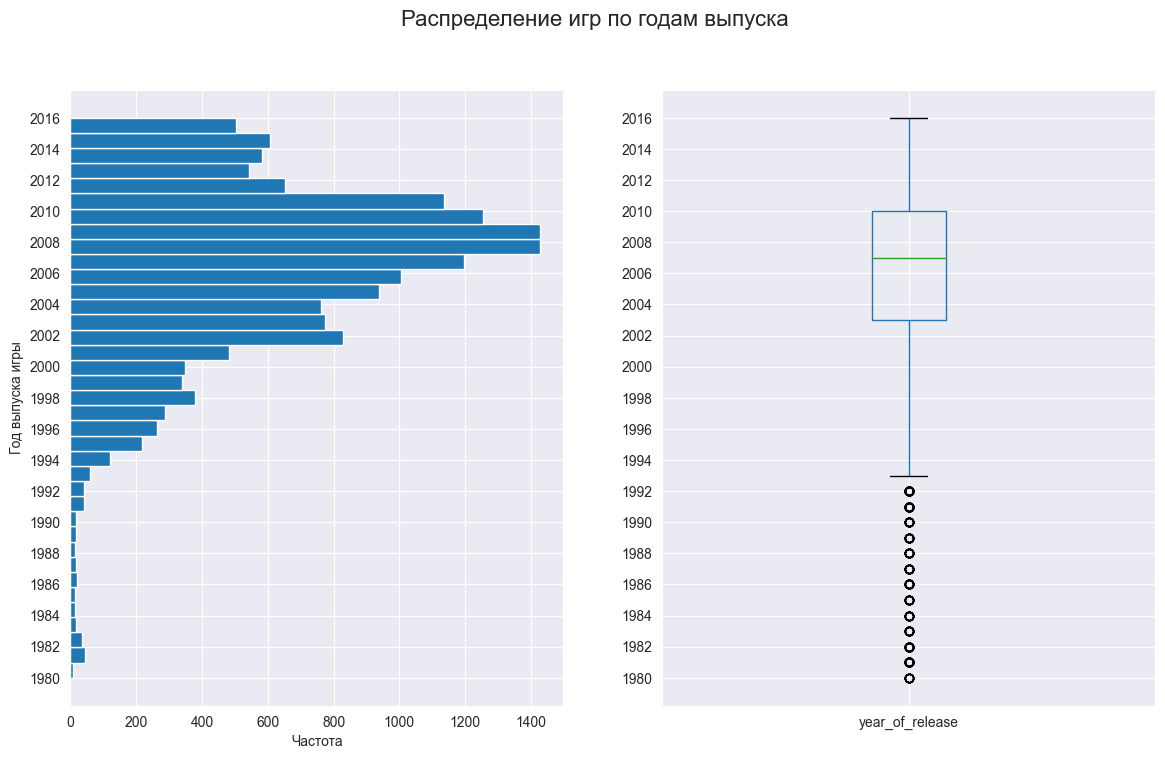

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

data['year_of_release'].plot(kind='hist', bins=37, orientation='horizontal', ax=axes[0])
data.boxplot(['year_of_release'], ax=axes[1])

axes[0].set_ylabel('Год выпуска игры')
axes[0].set_xlabel('Частота')

ticks = np.arange(data['year_of_release'].min(),
                     data['year_of_release'].max()+2,
                     2)
axes[0].set_yticks(ticks)
axes[1].set_yticks(ticks)
fig.suptitle('Распределение игр по годам выпуска', fontsize=16)

plt.show()

На боксплоте видно, что 50% всех позиций находится в диапазоне с 2003 по 2010 годы, а игры, которые выходили раньше 1993 года определяются как выбросы. Это поможет нам сформировать выборку для прогнозирования цены на 2017 год и далее, а пока посмотрим как менялись продажи в зависимости от платформы, на которую игра выпускалась.

#### `platform` и `total_sales`  — платформа и суммарные продажи

Для того, чтобы определить **актуальный период** для прогнозирования продаж на 2017 посмотрим как менялись продажи игр по разным игровым платформам и определим какой "срок жизни" такой платформы в среднем. Рассматривать будем 10 платформ, на которые выпускалось большинство игр с 1993 года.

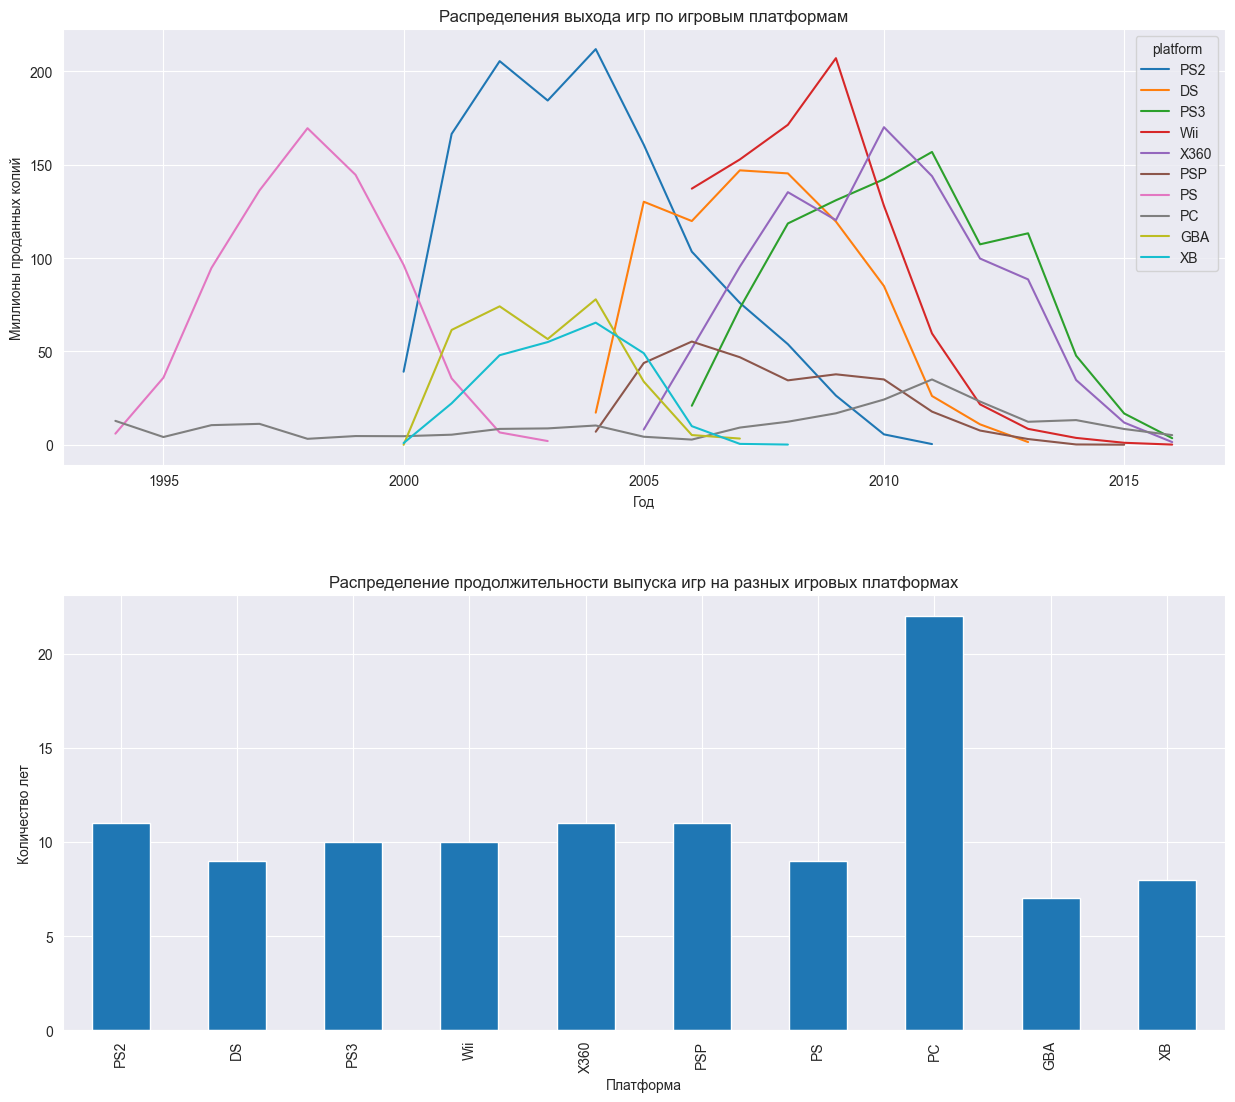

In [24]:
# определим данные с 1993 года в отдельную переменную
data_since_1993 = data[data['year_of_release']>=1993]

# выделим топ10 платформ по количеству игр
top10_platforms = data_since_1993['platform'].value_counts()[:10].index.tolist()

fig, axes = plt.subplots(2, 1, figsize=(15, 13))

data_since_1993.pivot_table(index=['year_of_release'],
                 columns=['platform'],
                 values='total_sales',
                 aggfunc='sum')[top10_platforms].plot(ax=axes[0])

#посчитаем дельту между первым и последним годом выпуска игры по платформам
platform_lifetime = data_since_1993.pivot_table(
    index=['platform'],values='year_of_release',
    aggfunc= lambda x: np.max(x)-np.min(x)).reset_index()
platform_lifetime.set_index('platform').loc[top10_platforms].plot(kind='bar', ax=axes[1])

# очистим переменную
del data_since_1993

axes[0].set_title('Распределения выхода игр по игровым платформам', fontsize=12)
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Миллионы проданных копий')

axes[1].set_title('Распределение продолжительности выпуска игр на разных игровых платформах', fontsize=12)
axes[1].set_xlabel('Платформа')
axes[1].set_ylabel('Количество лет')

axes[1].legend().remove()
plt.subplots_adjust(hspace=0.3)
plt.show()


In [25]:
# определим срок жизни платформы
lifetime = data.pivot_table(index='platform',
                             values='year_of_release',
                             aggfunc=['min', 'max']).reset_index()
lifetime['delta'] = lifetime['max'] - lifetime['min'] + 1
val = lifetime['delta'].median()
print(f'Медианное время жизни игровой платформы составляет: {int(val)} лет')

Медианное время жизни игровой платформы составляет: 7 лет


На графиках представлены данные начиная с 1993 года - минимальный год из анализа `year_of_release` на боксплоте. 

На графике №1 видно как продавались игры по 10 наиболее популярным игровым платформам. Обратим внимание, что с 2009-2010 начинается падение продаж и к 2016 году приближается к 0.

На графике №2 представлено ***время жизни*** **\*** поколений игровых платформ. Медианное значение по всем платформам составляет 7 лет. Явным фаворитом является PC и это неудивительно, ведь аббревиатура платформы 'PC' существовала с момента как придумали персональные компьютеры и игры на PC выпускаются с начала его сущестования по наши дни. 

Определим **актуальный период**, на основе которого можно будет построить прогноз продаж магазина "Стримчик". При определении актулального периода важно знать, что данная сфера быстро развивается и тренды могут поменяться за 2 - 5 лет. Попробуем взять данные за 2013, 2014, 2015 и 2016 год.

\****время жизни*** рассчитывается как разница между самым поздним годом, в котором выпустили игру на конкретную платформу и самым ранним

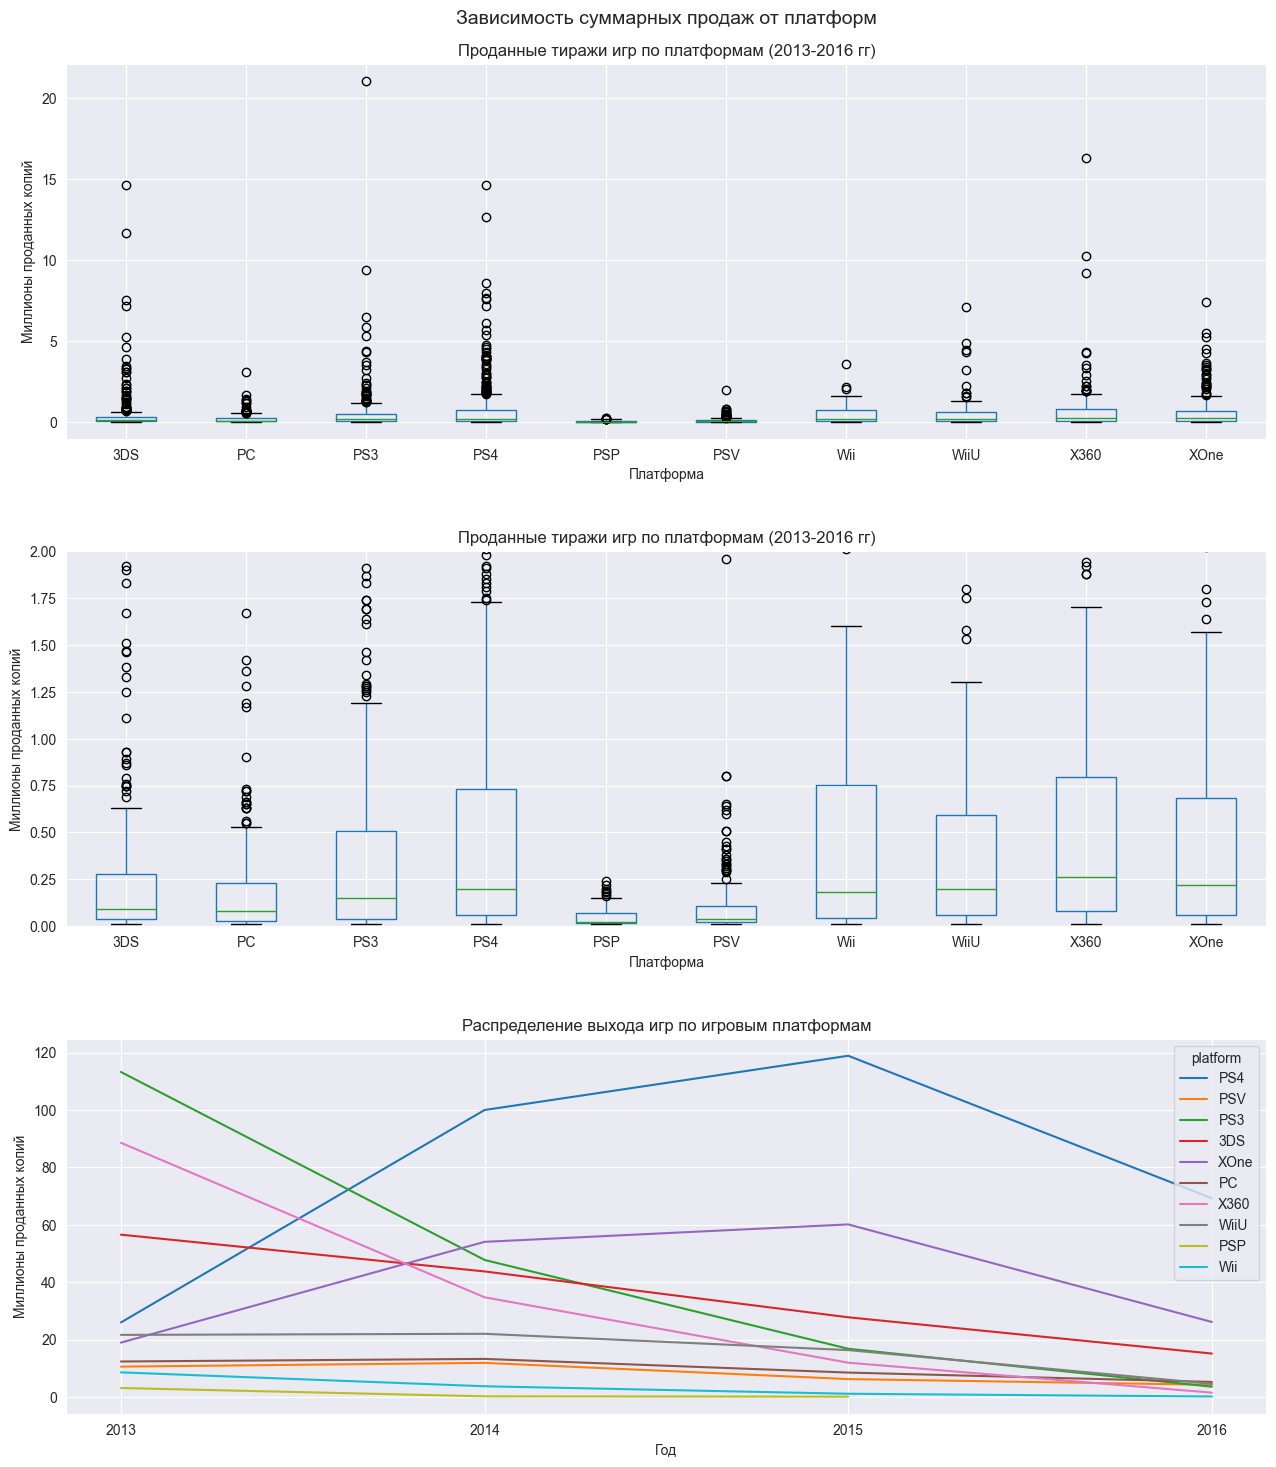

In [26]:
start_year = 2013
data = data[data['year_of_release']>= start_year]

# определим новый топ платформ уже для актуального периода
top10_platforms = data['platform'].value_counts()[:10].index.tolist()

fig, axes = plt.subplots(3, 1, figsize=(15, 18))

data.query('platform in @top10_platforms').boxplot(column='total_sales',
                                                   by='platform',
                                                   ax=axes[0])

data.query('platform in @top10_platforms').boxplot(column='total_sales',
                                                   by='platform',
                                                   ax=axes[1])

data.pivot_table(index=['year_of_release'],
                 columns=['platform'],
                 values='total_sales',
                 aggfunc='sum')[top10_platforms].plot(ax=axes[2])

axes[0].set_title(f'Проданные тиражи игр по платформам ({start_year}-2016 гг)', fontsize=12)
axes[0].set_xlabel('Платформа')
axes[0].set_ylabel('Миллионы проданных копий')

axes[1].set_title(f'Проданные тиражи игр по платформам ({start_year}-2016 гг)', fontsize=12)
axes[1].set_xlabel('Платформа')
axes[1].set_ylabel('Миллионы проданных копий')
axes[1].set_ylim(0,2)

axes[2].set_title('Распределение выхода игр по игровым платформам', fontsize=12)
axes[2].set_xlabel('Год')
axes[2].set_ylabel('Миллионы проданных копий')
axes[2].set_xticks([i for i in range(start_year, 2016+1)])

fig.suptitle('Зависимость суммарных продаж от платформ', fontsize=14, y=0.93)
plt.subplots_adjust(hspace=0.3)

plt.show()

С помощью боксплотов можем оценить, что наибольшие продажи соответствуют платформам таких компаний, как Sony(PS4, PS3, PSP, PSV), Nintendo(Wii, WiiU, DS, 3DS), Microsoft (X360, XOne). Обратим внимание, что в новом разрезе данных добавились такие консоли, как PS4 и XOne (более поздние версии консолей PS3 и X360). Продажи игр по ним сопоставимы с этими же консолями предыдущих версий. На графике №3 видим рост продаж игр на PS4 и Xone с 2013 по 2015 год, в то время как по остальным платформам идет снижение. Предполагаем, что игры на данные консоли в 2017 будут максимально актуальны.

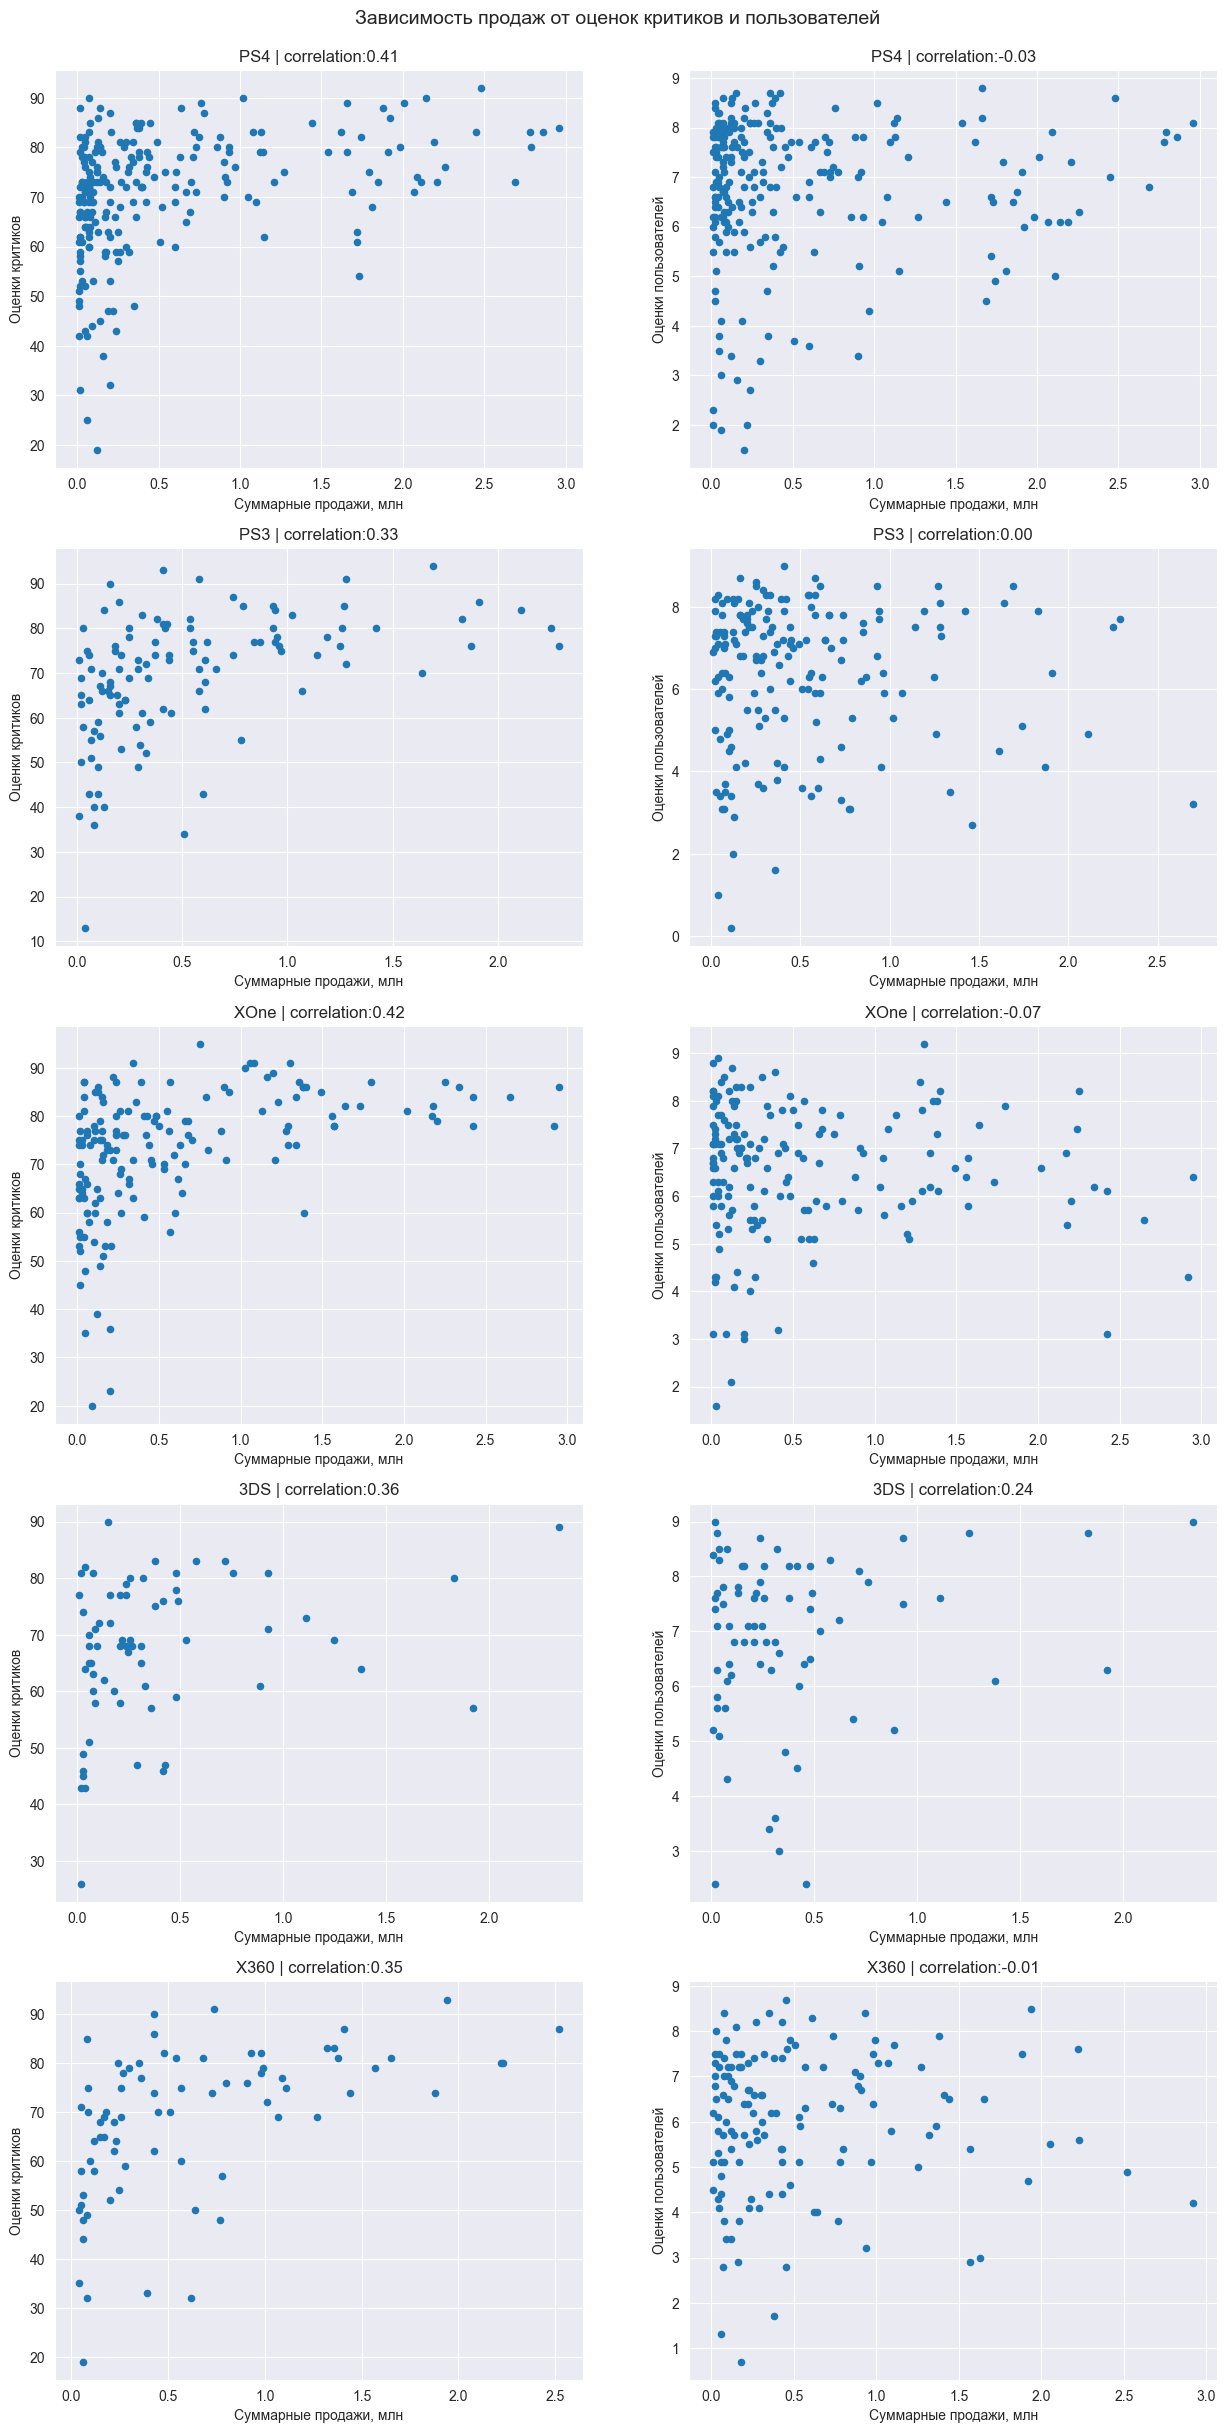

Корреляция между суммарными продажами и двуми видами оценок (critic и user):


,critic_score,user_score
PS4,0.41,-0.03
PS3,0.33,0.00
XOne,0.42,-0.07
3DS,0.36,0.24
X360,0.35,-0.01


In [27]:
# создадим словарь, в который сложим значения корреляций
corr = {}

# определим для какого количества платформ будем строить графики
n = 5

# определим платформы с максимальными продажами
platforms = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:n].tolist()

fig, axes = plt.subplots(n, 2, figsize=(15, 30))
fig.suptitle('Зависимость продаж от оценок критиков и пользователей', fontsize=14, y=0.9)

# ограничим часть продаж для выведения графика
limit_sales = 3

for i in range(0, n):
    
    corr[platforms[i]] = []
    
    for j in range(1, 3):
        if j==1:
            data[(data['platform']==platforms[i])&(data['total_sales']<=limit_sales)].plot(kind='scatter',
                                                                                           y='critic_score',
                                                                                           x='total_sales',
                                                                                           ax=axes[i, j-1])
            # посчитаем корреляцию
            r = data[data['platform']==platforms[i]][['critic_score', 'total_sales']].corr().iloc[0,1]
            corr[platforms[i]].append(round(r,2))
            
            axes[i, j-1].set_title(f'{platforms[i]} | correlation:{r:.2f}')
            axes[i, j-1].set_ylabel('Оценки критиков')
            axes[i, j-1].set_xlabel('Суммарные продажи, млн')
        else:
            data[(data['platform']==platforms[i])&(data['total_sales']<=limit_sales)].plot(kind='scatter',
                                                                                           y='user_score',
                                                                                           x='total_sales',
                                                                                           ax=axes[i, j-1])
            
            r = data[data['platform']==platforms[i]][['user_score', 'total_sales']].corr().iloc[0,1]
            corr[platforms[i]].append(round(r,2))
            
            axes[i, j-1].set_title(f'{platforms[i]} | correlation:{r:.2f}')
            axes[i, j-1].set_ylabel('Оценки пользователей')
            axes[i, j-1].set_xlabel('Суммарные продажи, млн')
            
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

print('Корреляция между суммарными продажами и двуми видами оценок (critic и user):')
display(pd.DataFrame(corr, index=['critic_score', 'user_score']).T)

На диаграммах рассеяния представлена зависимость между суммарными продажами с оценками пользователей и оценками критиков по платформам, которые имеют максимальные продажи (топ5 платформ). Корреляция суммарных продаж с оценками критиков выше, чем с оценками пользователей. Можем предположить, что критики точнее предсказывают успешность продаж игр, чем пользователи.

#### `genre`  — жанр игры

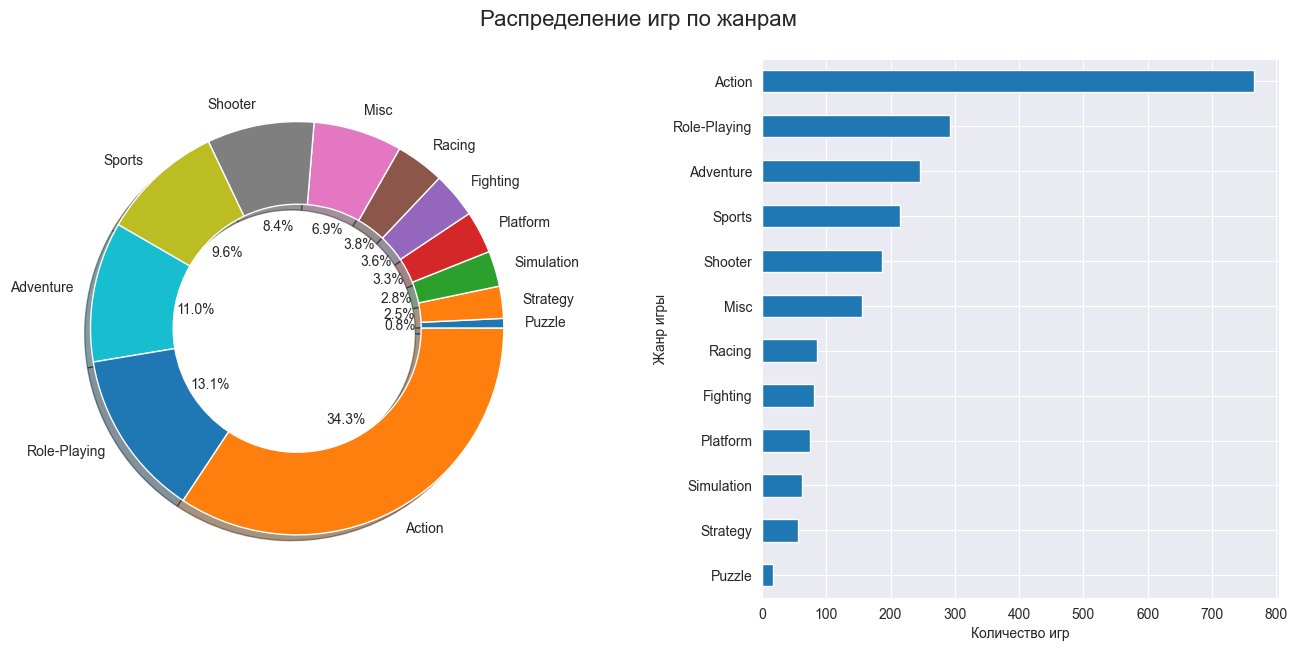

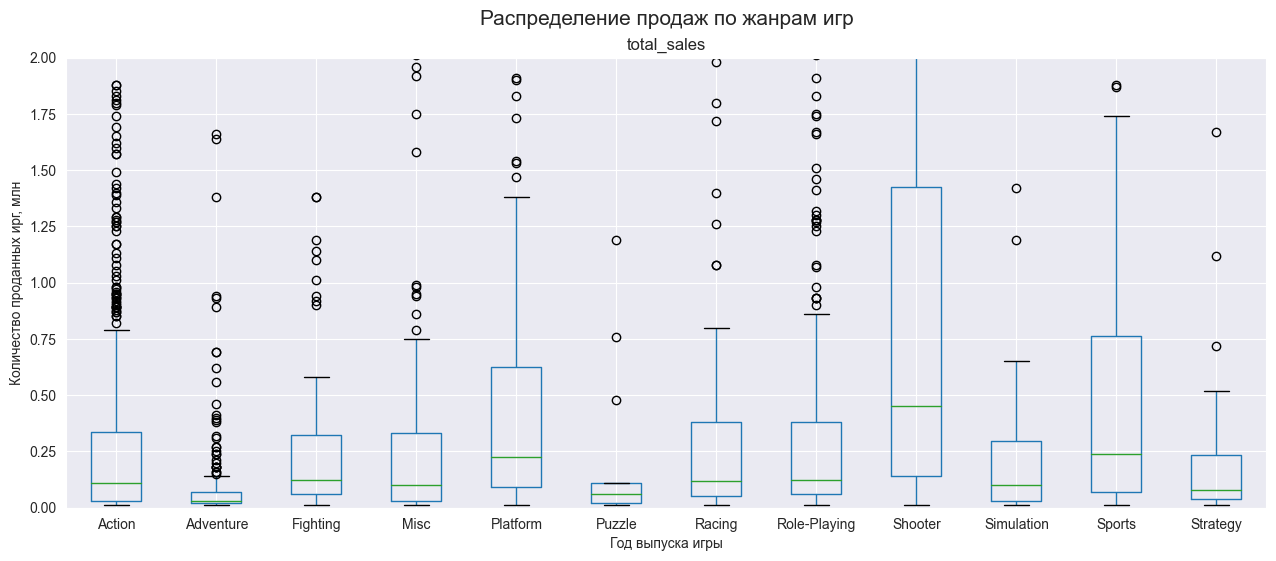

Медианные значения продаж по жанрам:


genre,Shooter,Sports,Platform,Role-Playing,Fighting,Racing,Action,Simulation,Misc,Strategy,Puzzle,Adventure
total_sales,0.45,0.24,0.225,0.125,0.125,0.12,0.11,0.1,0.1,0.08,0.06,0.03


In [28]:
# построим распределение игр по жанрам
fig, axes = plt.subplots(1, 2, figsize=(16,7))
data.pivot_table(index='genre',
                 values='name',
                 aggfunc='count').sort_values('name').plot(kind='pie',
                                                           y='name',
                                                           ax=axes[0],
                                                           legend=False,
                                                           autopct='%1.1f%%',
                                                           shadow=True,
                                                           wedgeprops=dict(width=0.4),
                                                           pctdistance=.5)
data.pivot_table(index='genre',
                 values='name',
                 aggfunc='count').sort_values('name').plot(kind='barh', ax=axes[1])

fig.suptitle('Распределение игр по жанрам', fontsize=16, y=0.95)

axes[0].set_ylabel('')
axes[1].set_ylabel('Жанр игры')

axes[1].set_xlabel('Количество игр')
axes[1].legend().remove()

plt.subplots_adjust(wspace=0.4)
plt.show()

# определим порядок самых прибыльных игр
cols = data.pivot_table(index=['genre'],
                 values='total_sales',
                 aggfunc='sum').sort_values('total_sales', ascending=False).index

fig, axes = plt.subplots(1, figsize=(15, 6))
data.boxplot(column='total_sales', by='genre', ax=axes)

fig.suptitle('Распределение продаж по жанрам игр', fontsize=15, y=0.98)
axes.set_ylabel('Количество проданных ирг, млн')
axes.set_xlabel('Год выпуска игры')
axes.set_ylim(0, 2)

plt.show()

print('Медианные значения продаж по жанрам:')
display(pd.DataFrame(data.groupby('genre')['total_sales'].median().sort_values(ascending=False)).T)

Самым распространенным игровым жанром является Экшен (34.3% всего рынка), затем идут жанры: Role-Playing, Adventure, Sports, Shooter. Однако топ 5 самых прибыльных игр отличается от общего распределения игр. В него входят следующие жанры: 
1. Shooter
2. Sports
3. Platform
4. Role-Playing
5. Fighting

Обратим внимание, что наиболее распространенные на рынке жанры не являются наиболее прибыльными. Так жанр Shooter является самым прибыльным (по оценке медианных значений), но игры данного жанра занимают только 5 место среди всех остальных жанров с долей в 8.4%.

### Портрет пользователя каждого региона

В данном разделе посмотрим в каких регионах наиболее популярными являются определенные игровые платформы, как влиется рейтинг ESRB на продажи и какие жанры предпочитают пользователи в том или ином регионе.

#### `platform` — платформа

In [29]:
# создадим вспомогательные для графиков справочники
regions = {'NA': 'na_sales',
           'EU': 'eu_sales',
           'JP': 'jp_sales',
           'OTHER': 'other_sales'}

platform_colors = {'X360': 'tab:blue',
                  'PS3': 'tab:orange',
                  'DS': 'tab:green',
                  'PS4': 'tab:red',
                  '3DS': 'tab:purple',
                  'Wii': 'tab:brown',
                  'XOne': 'tab:gray',
                  'WiiU': 'tab:olive',
                  'PC': 'tab:cyan',
                  'PSP': 'tab:pink',
                  'PSV': 'oldlace',
                  'PS2': 'avender',
                  'OTHER': 'lightgray'}

genre_colors = {'Misc': 'tab:blue',
                'Action': 'tab:orange',
                'Role-Playing': 'tab:green',
                'Shooter': 'tab:red',
                'Racing': 'tab:purple',
                'Platform': 'tab:brown',
                'Simulation': 'tab:gray',
                'Sports': 'tab:olive',
                'Fighting': 'tab:cyan',
                'Strategy': 'tab:pink',
                'Adventure': 'oldlace',
                'Puzzle': 'avender',
                'OTHER': 'lightgray'}

ersb_colors = {'Для всех': 'tab:blue',
               'Для взрослых': 'tab:orange',
               'Для всех от 10 лет': 'tab:red',
               'Подросткам': 'tab:purple',
               'Для детей младшего возраста': 'tab:gray',
               'Рейтинг ожидается': 'oldlace',
               'Без рейтинга': 'lightgray'}

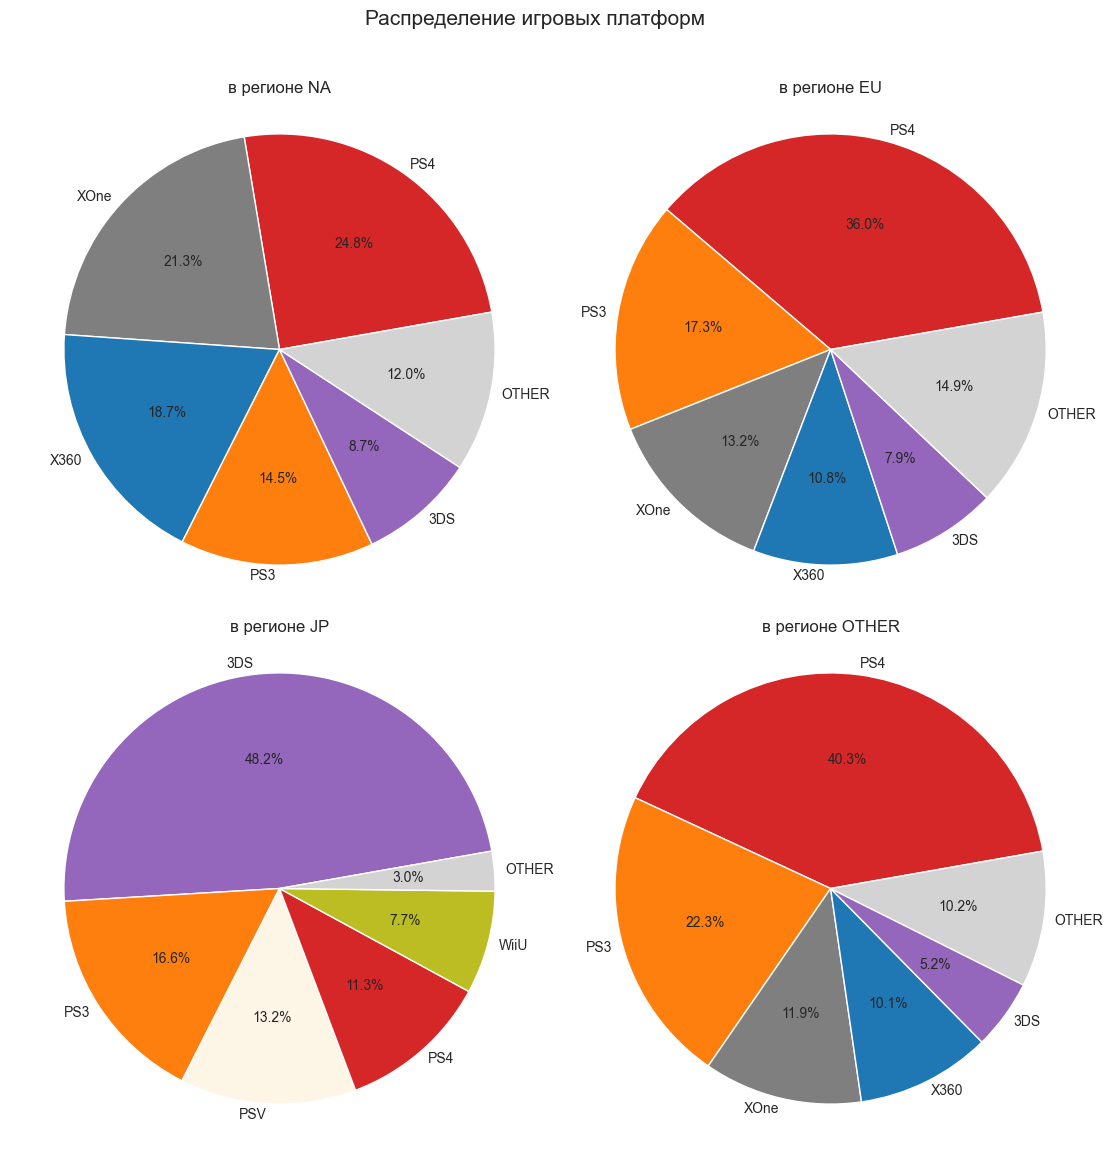

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for i, region in enumerate(regions):
        row, col = int(i/2), int(i%2)

        # определим топ5 популярных платформ в регионе
        top5 = data.pivot_table(index='platform',
                                values=regions[region],
                                aggfunc='sum').sort_values(regions[region],
                                                           ascending=False).index[:5].tolist()
        
        # построим доли продаж по регионам по топ5 платформам
        region_data = data.pivot_table(index='platform',
                                       values=regions[region],
                                       aggfunc='sum').loc[top5]
        
        # добавим строку с продажами прочих платформ, которые не вошли в топ
        value = data.pivot_table(index='platform',
                         values=regions[region],
                         aggfunc='sum').sort_values(regions[region], ascending=False)[5:].sum().values[0]
        new_row = {regions[region]: value}
        region_data = pd.concat([region_data, pd.DataFrame(new_row, index=['OTHER'])])
        
        region_data.plot(kind='pie', y=regions[region], ax=axes[row, col],
                                                       colors=[platform_colors[i] for i in region_data.index],
                                                       legend=False,
                                                       autopct='%1.1f%%',
                                                       startangle=10,
                                                       labeldistance=1.05)
        
        
        axes[row, col].set_title(f'в регионе {region}', y=0.96)
        axes[row, col].set_ylabel('')

fig.suptitle('Распределение игровых платформ', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0, wspace=-0.2)
plt.show()

Основные различия между Северной Америкой и Европой заключаются в том, что в Северной Америке доли XOne и X360 примерно в 2 раза больше, чем в остальных регионах (искл. Японию) и составляют суммарно около 40% от общего рынка игровых платформ, в то время как, например, в Европе платформы от американской компании Microsoft составляют 24% от общего объема. Распределение игровых платформ в Японии координально отличается от остального мира. Отметим, что на японском рынке почти отсутствуют американские игровые платформы (возможно они лежат в прочих, которые составляют 3%). А наибольшую часть занимают игры для платформы 3DS (почти половина всего рынка), которая в остальном мире хоть и вошла в топ5 платформ, но распространена гораздо скромнее (до 8.7% в Северной Америке).

#### `genre` — жанр игры

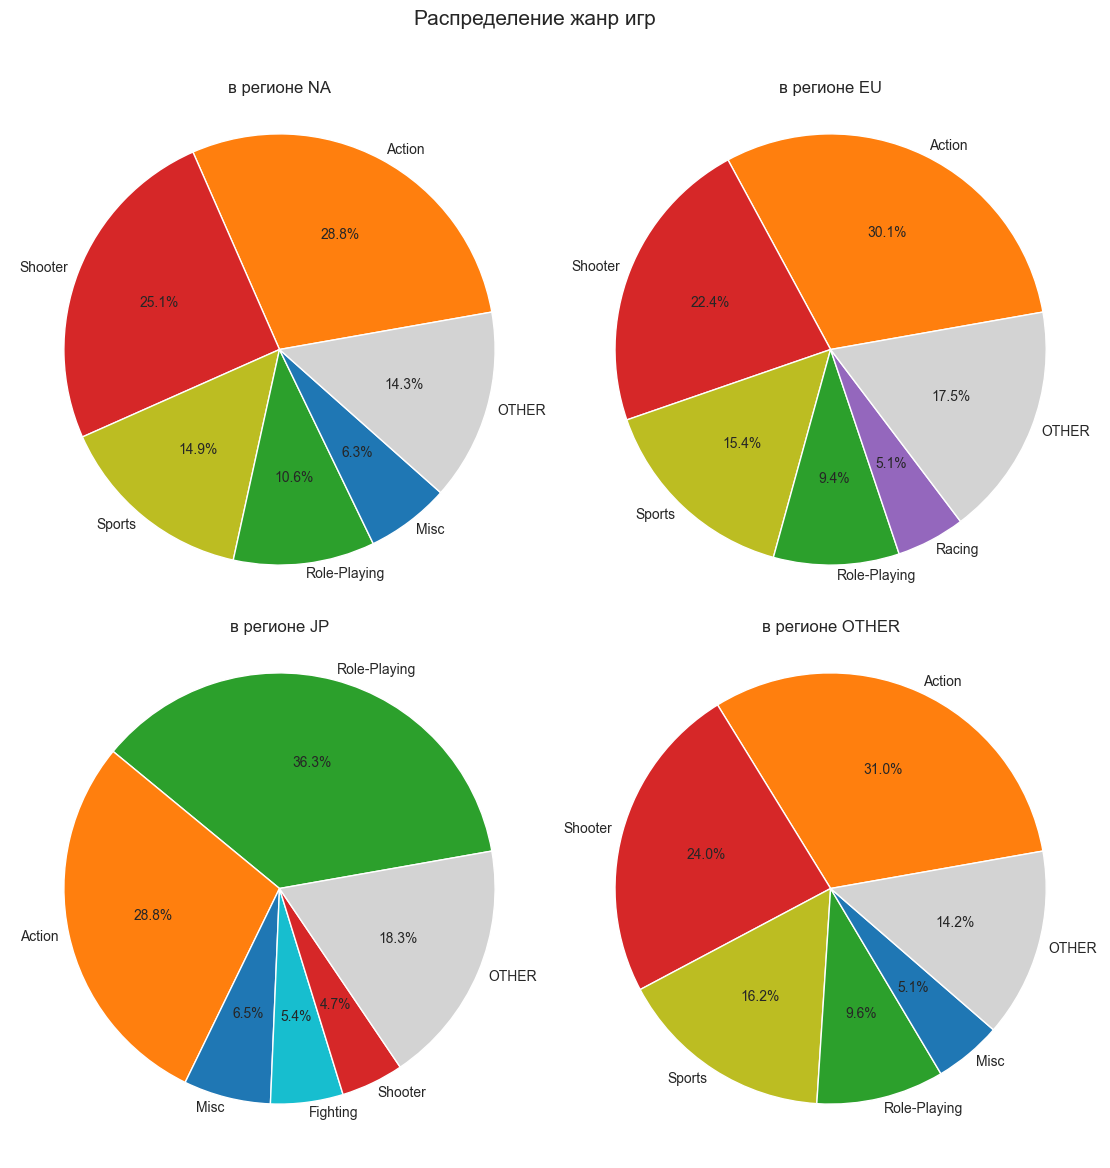

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for i, region in enumerate(regions):
        row, col = int(i/2), int(i%2)

        # определим топ5 популярных жанров в регионе
        top5 = data.pivot_table(index='genre',
                                values=regions[region],
                                aggfunc='sum').sort_values(regions[region],
                                                           ascending=False).index[:5].tolist()
        
        # построим доли продаж по регионам по топ5 платформам
        region_data = data.pivot_table(index='genre',
                                       values=regions[region],
                                       aggfunc='sum').loc[top5]
        
        # добавим строку с продажами прочих платформ, которые не вошли в топ
        value = data.pivot_table(index='genre',
                         values=regions[region],
                         aggfunc='sum').sort_values(regions[region], ascending=False)[5:].sum().values[0]
        new_row = {regions[region]: value}
        region_data = pd.concat([region_data, pd.DataFrame(new_row, index=['OTHER'])])
        
        region_data.plot(kind='pie', y=regions[region], ax=axes[row, col],
                                                       colors=[genre_colors[i] for i in region_data.index],
                                                       legend=False,
                                                       autopct='%1.1f%%',
                                                       startangle=10,
                                                       labeldistance=1.05)
        
        
        axes[row, col].set_title(f'в регионе {region}', y=0.96)
        axes[row, col].set_ylabel('')

fig.suptitle('Распределение жанр игр', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0, wspace=-0.2)
plt.show()

На данных круговых диаграмах изображено распределение игровых жанров по регионам. Во всех регионах за исключением Японии видим абсолютно одинаковое соотношение игровых жанров среди 5 наиболее самых популярных в данном регионе: 
1. Action (28.8-31%)
2. Shooter (22.4-25.1%)
3. Sports (14.9-16.2%)
4. Role-Playing (9.4-10.6%)
5. Misc/Racing 

Основные различия снова видим в Японии относительно всего остального мира. В даном регионе существенную долю рынка занимают игры жанра Role-Playing (36.3%), а вот доля второго по распространенности жанра Action примерно совпадает с другими регионами. Также в топ5 вошел такой жанр как Fighting, а игры жанра Shooter составляют всего 4.7%.

#### `Rating` — рейтинг от организации ESRB

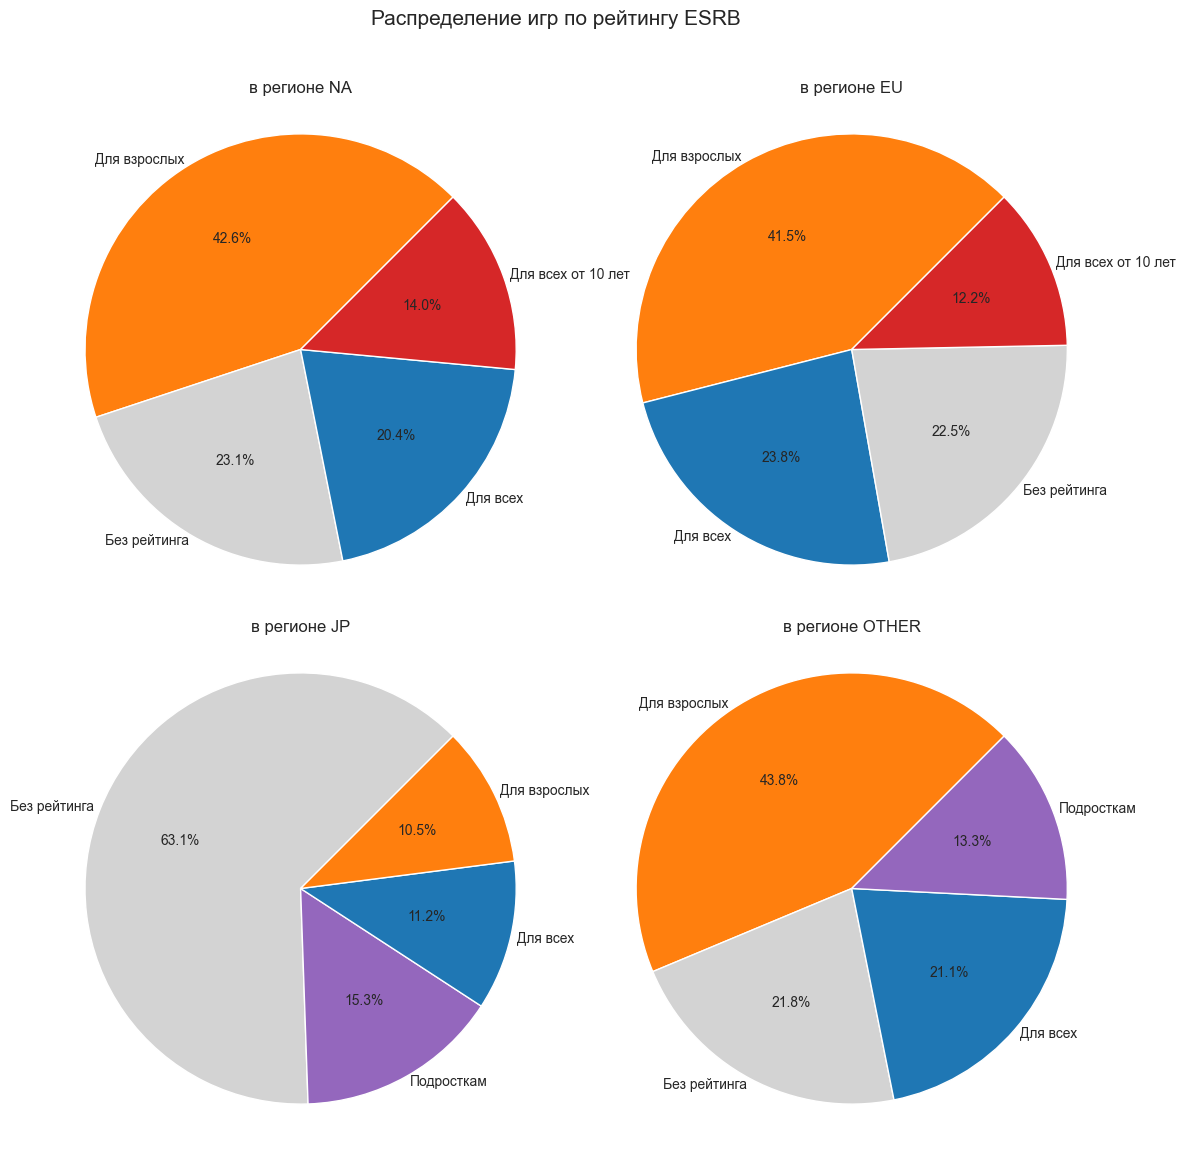

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for i, region in enumerate(regions):
        row, col = int(i/2), int(i%2)
        
        
        ersb_top = data.pivot_table(index='rating_info',
                                values=regions[region],
                                aggfunc='sum').sort_values(regions[region],
                                                           ascending=False).index.tolist()[:4]
        
        # построим доли продаж по регионам по топ5 жанрам
        data.pivot_table(index='rating_info',
                         values=regions[region],
                         aggfunc='sum').loc[ersb_top].plot(kind='pie', y=regions[region], ax=axes[row, col],
                                                           colors=[ersb_colors[i] for i in ersb_top],
                                                           legend=False,
                                                           autopct='%1.1f%%',
                                                           startangle=45,
                                                           labeldistance=1.03)
        
        
        axes[row, col].set_title(f'в регионе {region}', y=0.96)
        axes[row, col].set_ylabel('')

fig.suptitle('Распределение игр по рейтингу ESRB', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0, wspace=-0.2)
plt.show()

Представленные круговые диаграммы показывают распределение игр с различным рейтингом ESRB по регионам. Видим похожее соотношение, как и с диаграммами по жанру между регионами - снова выделяется Япония. Во всем мире наиболее распространенный рейтинг игр - это "Игры для взрослых", затем приблизительно в равных долях игры "Без рейтинга" и "Для всех". 

В Японии же на первом месте игры "Без рейтинга", а затем "Игры для подростков". Учитывая, что рейтинг есть у игр, которые выпускаются в Америке и Канаде можем предположить, что на японском рынке представлены в основном игры местного производства (63.1%).

## Проверка гипотез

В данном разделе проверим гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One(k1) и PC(k2) одинаковые
2. Средние пользовательские рейтинги жанров Action(k1) (англ. «действие», экшен-игры) и Sports(k2) (англ. «спортивные #соревнования») разные.

Cформулируем их:

1. 
* H0: Средние пользовательские рейтинги платформ Xbox One(k1) и PC(k2) одинаковые
* HA: Средние пользовательские рейтинги платформ Xbox One(k1) и PC(k2) разные

2. 
* H0: Средние пользовательские рейтинги жанров Action(k1) и Sports(k2) одинаковые
* HA: Средние пользовательские рейтинги жанров Action(k1) и Sports(k2) разные

Нулевая и альтернативная гипотезы будут выглядеть так:

* H0: k1 = k2
* HA: k1 ≠ k2

В данном случае нам необходимо проверить гипотезу о равенстве средних двух генеральных совокупностей. Уровень статистической значимости установим на отметке в 5%.

In [33]:
# получим две выборки для проверки первой гипотезы
xbox_data = data[(data['platform']=='XOne')&(data['user_score'].notna())]['user_score']
pc_data = data[(data['platform']=='PC')&(data['user_score'].notna())]['user_score']

# установим уровень значимости
alpha = 0.05

results = st.ttest_ind(xbox_data,
                       pc_data,
                       equal_var=False) # выборки разного размера - установим False

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print()
print('Срдние пользовательские рейтинги по платформам:')
display(data.pivot_table(index='platform', values='user_score', aggfunc='mean').loc[['PC','XOne']])

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу

Срдние пользовательские рейтинги по платформам:


,user_score
platform,
PC,6.269677
XOne,6.521429


В результате проверки первой гипотезы мы не смогли отвергнуть нулевую гипотезу. Таким образом, можем сказать, что нет статистически значимых различий между пользовательскими оценками игр на PC и Xbox.

In [34]:
# получим две выборки для проверки второй гипотезы
action_data = data[(data['genre']=='Action')&(data['user_score'].notna())]['user_score']
sports_data = data[(data['genre']=='Sports')&(data['user_score'].notna())]['user_score']

# установим уровень значимости
alpha = 0.05

results = st.ttest_ind(action_data,
                       sports_data,
                       equal_var=False) # выборки разного размера - установим False

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print()
print('Срдние пользовательские рейтинги по жанрам:')
display(data.pivot_table(index='genre', values='user_score', aggfunc='mean').loc[['Action','Sports']])

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу

Срдние пользовательские рейтинги по жанрам:


,user_score
genre,
Action,6.837532
Sports,5.238125


В ходе проверки второй гипотезы нам удалось отвергнуть нулевую гипотезу в пользу альтернативной. Значит можно предполагать, что средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

В ходе выполнения проекта по анализу исторических данных продаж компьютерных игр были выявлены закономерности, которые определяют успешность игры. Информация, полученная при работе над проектом, может помочь для проведения рекламных кампаний для интернет-магазина «Стримчик», который специализируется на продаже компьютерных игр по всему миру.

Важными показателями, влияющими на успешность продажи игр, являются оценки экспертов, жанры и платформы. При этом возрастной рейтинг игр, выставляемый ассоциацией ESRB, также соответствует одному из ключевых показателей, поскольку он помогает определить, какие категории пользователей будут заинтересованы в данной игре. Важно отметить, что был определен актуальный период, за который были выбраны игры для анализа. Данный период включает в себя данные игр с 2013 по 2016 год. 

Оценки пользователей не оказывают значительного влияния на продажи игр, в то время как оценки критиков коррелируют с общими продажами, поэтому следует прислушиваться к мнению критиков.

Результаты статистического теста подтверждают различия в средних пользовательских рейтингах жанров Action и Sports, что может помочь в прогнозировании продаж игр этих жанров. В целом, все вышеперечисленные факторы следует учитывать при разработке и маркетинге игр, чтобы достичь оптимальных продаж.

Таким образом, мы можем сформулировать рекомендации для проведения рекламных кампаний в том или ином регионе:

1. **Северная Америка и Европа**
<br><br>Для рекламной кампании в Северной Америке предпочтительно делать акцент на рекламе игр для таких платформ, как PS4 и XOne. Для Европы, в целом, можно выбрать только платформу PS4. Далее рекомендации для двух данных регионов будут одинаковые. Стоит рекламировать такие жанры игр, как Action и Shooter. Желательно, чтобы рейтинг ESRB у игр был "M". Для выбора конкретных игр можно посмотреть на оценки критиков и выбрать, например, несколько игр с наибольшими оценками (данная рекомендация будет работать для любого региона). <br><br>

2. **Япония**
<br><br>В Японии будет актуально как нигде рекламировать игры для платформы 3DS. Таким образом мы охватим около половины всего рынка. Выбранные для рекламы игры должны относиться к жанру Role-Playing или Action. Вероятнее всего у данных игр не будет рейтинга ESRB и это абсолютно нормально.<br><br>